In [13]:
import pathlib
import numpy as np
data_dir = pathlib.Path("data/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['beef_tartare' 'eggs_benedict' 'miso_soup']


In [14]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


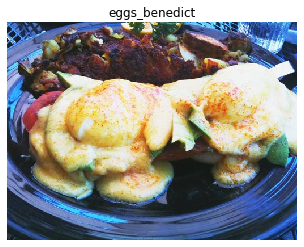

In [22]:
img = view_random_image(target_dir="data/train/",
                        target_class="eggs_benedict")

Image shape: (384, 512, 3)


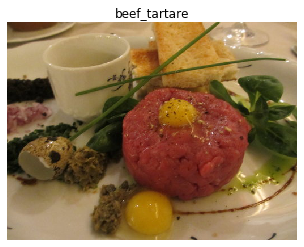

In [23]:
img = view_random_image(target_dir="data/train/",
                        target_class="beef_tartare")

Image shape: (384, 512, 3)


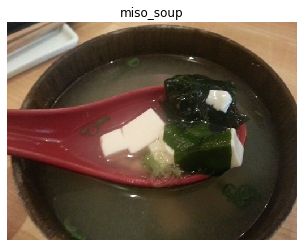

In [24]:
img = view_random_image(target_dir="data/train/",
                        target_class="miso_soup")

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "data/train/"
test_dir = "data/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 225 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [27]:
# Create a CNN model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [28]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=7,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/7
8/8 [==============================] - 46s 6s/step - loss: 1.1126 - accuracy: 0.3067 - val_loss: 1.0406 - val_accuracy: 0.4880
Epoch 2/7
8/8 [==============================] - 14s 2s/step - loss: 0.9998 - accuracy: 0.5956 - val_loss: 0.9890 - val_accuracy: 0.4987
Epoch 3/7
8/8 [==============================] - 16s 2s/step - loss: 0.8716 - accuracy: 0.6089 - val_loss: 0.9178 - val_accuracy: 0.5800
Epoch 4/7
8/8 [==============================] - 16s 2s/step - loss: 0.8032 - accuracy: 0.6311 - val_loss: 0.9095 - val_accuracy: 0.5747
Epoch 5/7
8/8 [==============================] - 16s 2s/step - loss: 0.6707 - accuracy: 0.7333 - val_loss: 0.9625 - val_accuracy: 0.5720
Epoch 6/7
8/8 [==============================] - 16s 2s/step - loss: 0.6109 - accuracy: 0.7067 - val_loss: 0.9718 - val_accuracy: 0.5693
Epoch 7/7
8/8 [==============================] - 16s 2s/step - loss: 0.5907 - accuracy: 0.7244 - val_loss: 0.8857 - val_accuracy: 0.6120


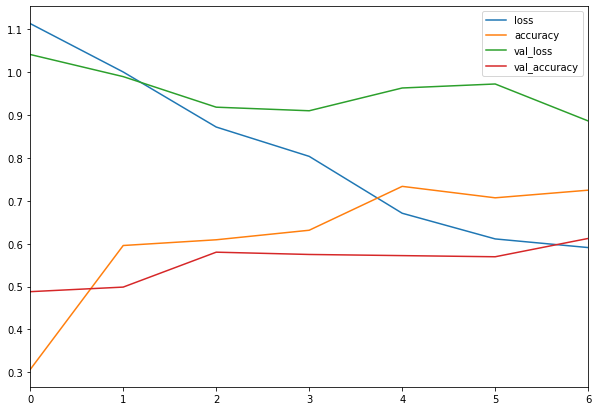

In [29]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [30]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [31]:
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels 
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

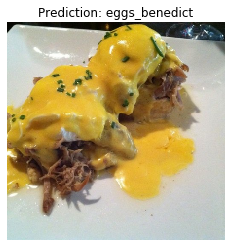

In [33]:
pred_and_plot(model_1, "data/train/eggs_benedict/607091.jpg", class_names)

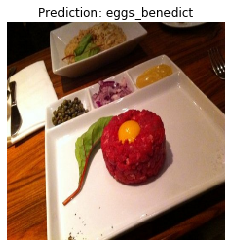

In [35]:
pred_and_plot(model_1, "data/train/beef_tartare/180013.jpg", class_names)

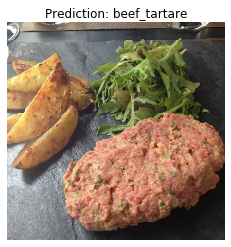

In [39]:
pred_and_plot(model_1, "data/train/beef_tartare/1743464.jpg", class_names)

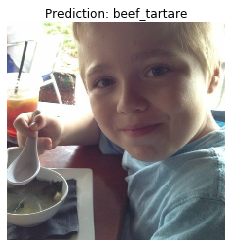

In [42]:
pred_and_plot(model_1, "data/train/miso_soup/1728897.jpg", class_names)